# Online News Popularity Data Set 
This dataset is provided by [UCI ML Dataset](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity).  It has got details about 39K articles published in Mashables and number of shares each article has got. The idea is to build a model to predict the number of shares. Before doing so, we will also try to perform certan feature selection and also perform EDA

First of all, let's get the data from UCI dataset. 


In [1]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip -O OnlineNewsPopularity.zip
!yes | unzip OnlineNewsPopularity.zip

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2019-09-05 02:15:44--  http://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7476401 (7.1M) [application/x-httpd-php]
Saving to: ‘OnlineNewsPopularity.zip’

OnlineNewsPopularit 100%[===================>]   7.13M  19.0MB/s    in 0.4s    

2019-09-05 02:15:44 (19.0 MB/s) - ‘OnlineNewsPopularity.zip’ saved [7476401/7476401]

Archive:  OnlineNewsPopularity.zip
   creating: OnlineNewsPopularity/
  inflating: OnlineNewsPopularity/OnlineNewsPopularity.names  
  inflating: OnlineNewsPopularity/OnlineNewsPopularity.csv  
yes: standard output: Broken pipe


The details of dataset is provided below

In [2]:
!cat OnlineNewsPopularity/OnlineNewsPopularity.names

1. Title: Online News Popularity

2. Source Information
    -- Creators: Kelwin Fernandes (kafc ‘@’ inesctec.pt, kelwinfc ’@’ gmail.com),
                 Pedro Vinagre (pedro.vinagre.sousa ’@’ gmail.com) and
                 Pedro Sernadela
   -- Donor: Kelwin Fernandes (kafc ’@’ inesctec.pt, kelwinfc '@' gmail.com)
   -- Date: May, 2015

3. Past Usage:
    1. K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision
       Support System for Predicting the Popularity of Online News. Proceedings
       of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence,
       September, Coimbra, Portugal.

       -- Results: 
          -- Binary classification as popular vs unpopular using a decision
             threshold of 1400 social interactions.
          -- Experiments with different models: Random Forest (best model),
             Adaboost, SVM, KNN and Naïve Bayes.
          -- Recorded 67% of accuracy and 0.73 of AUC.
    - Predicted attribute: online ne

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##  SKlearn libs for regressions
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

##Importing Libraries for Neural Nets
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation

import xgboost



Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Data Load and Understanding

Load the data and print shape of the data.

In [4]:
df = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv')
df.shape

(39644, 61)

We can see there are 39.6K data records with 61 columns. 1 target variable

Let us see how the data look like

In [5]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


Let us try to analyse null values in the input

In [6]:
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
column type,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
null values (nb),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can observe that, there are no null values in any of the columns, which is great news.. Let us now try to remove unwanted and non-value adding columns

In [7]:
cols_to_remove = ['url']
df = df.drop(['url'], axis=1)
df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## Data Cleaning, Outlier treatment

### No. of Shares
Let us analyse how the sharing data is spread

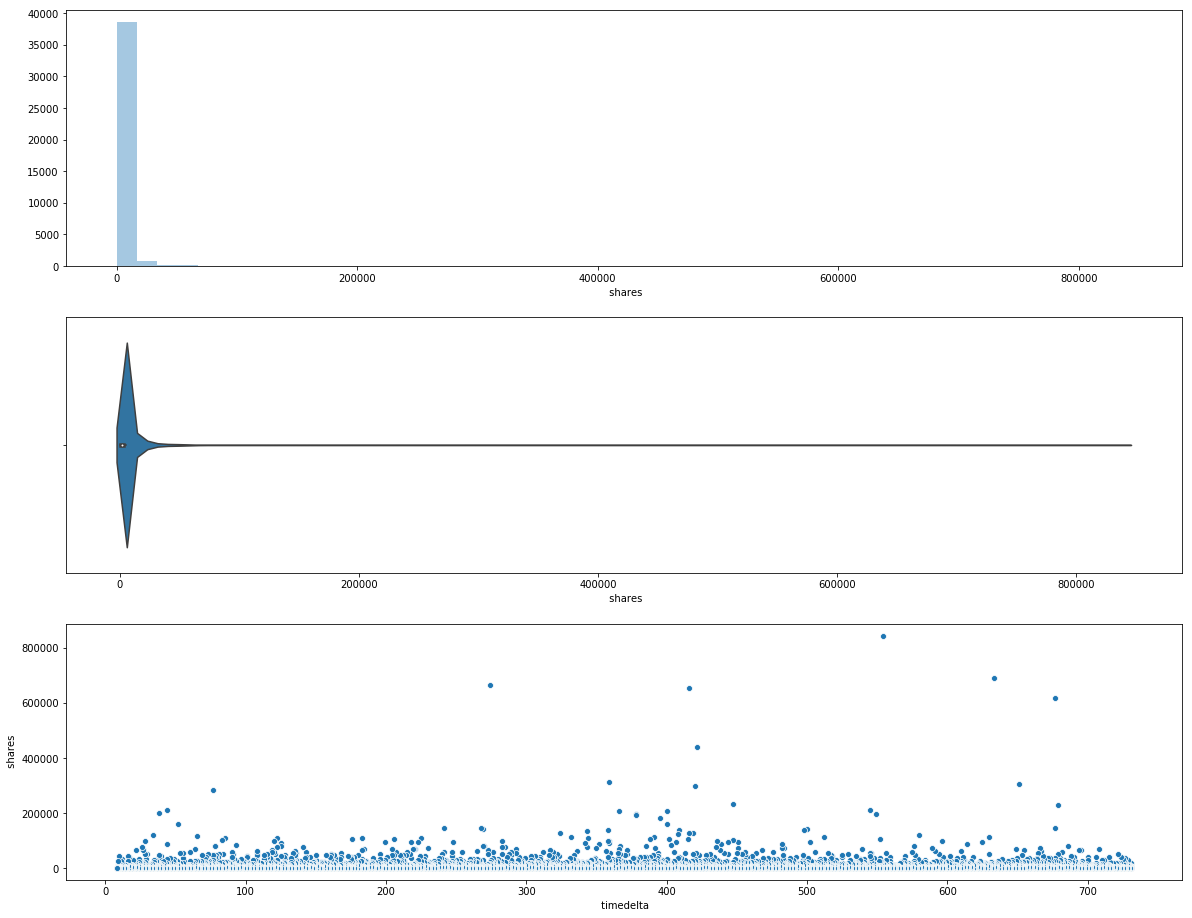

In [8]:
plt.subplots(3,1,figsize=(20,16))
plt.subplot(3,1,1)
sns.distplot(df[' shares'], hist=True, kde=False)
plt.subplot(3,1,2)
sns.violinplot(df[' shares'])
plt.subplot(3,1,3)
sns.scatterplot(data=df, x=' timedelta', y=' shares')

We can see that the data is very skewed. We can also observe that there are very low no. of articles with very large number of shares. The 3rd scatter plot confirms the same. 

So, next let us try to find and remove the **outliers**

In [9]:
Q1 = df[' shares'].quantile(0.25)
Q3 = df[' shares'].quantile(0.75)
IQR = Q3 - Q1
LTV= Q1 - (1.5 * IQR)
UTV= Q3 + (1.5 * IQR)
df = df.drop(df[df[' shares'] > UTV].index)
df.shape

(35103, 60)

After removing the outliers, let us try to plot the same graphs

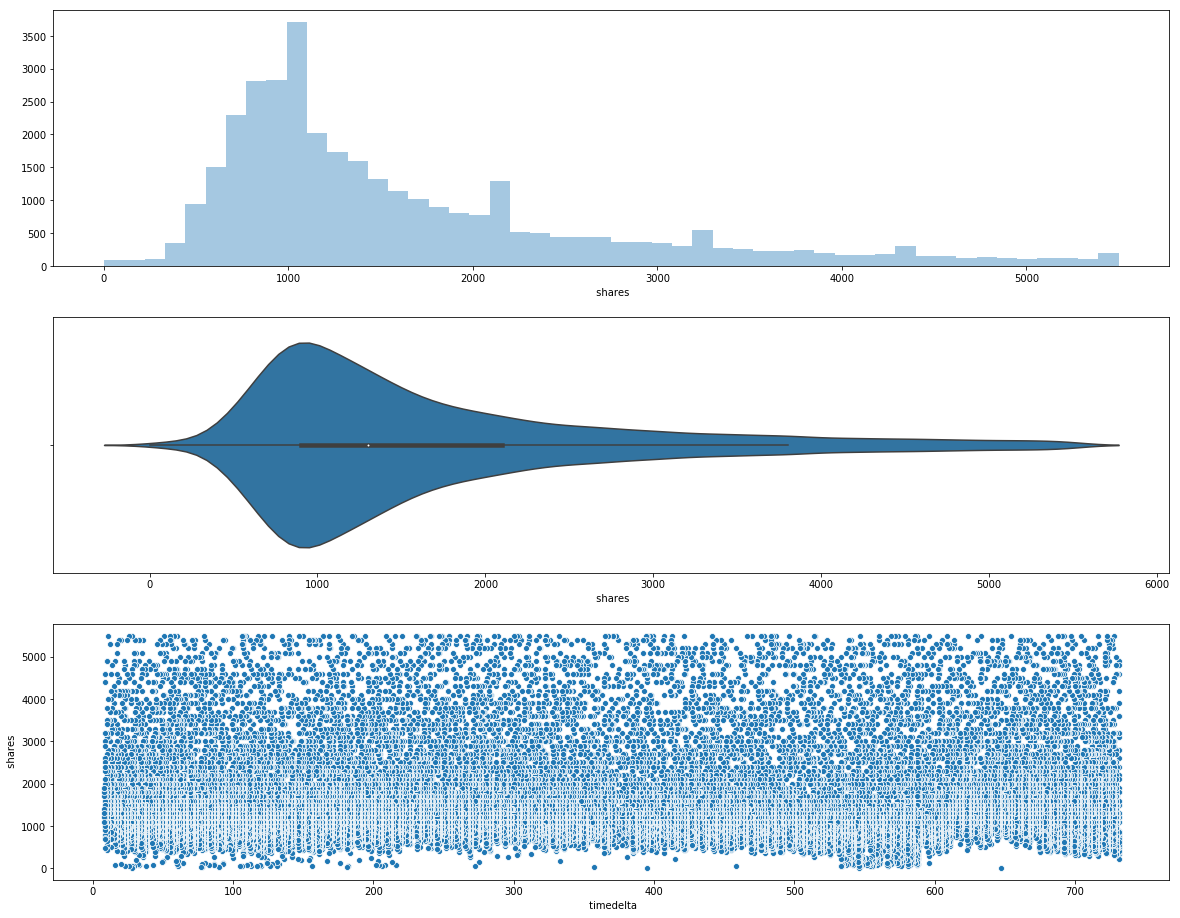

In [10]:
plt.subplots(3,1,figsize=(20,16))
plt.subplot(3,1,1)
sns.distplot(df[' shares'], hist=True, kde=False)
plt.subplot(3,1,2)
sns.violinplot(df[' shares'])
plt.subplot(3,1,3)
sns.scatterplot(data=df, x=' timedelta', y=' shares')

Now the data looks really good for next steps.. 

# Feature selection
We have seen that there are around 60 features. In this section, we analyse statistically and find which are all the important features to consider

### Correlation Analysis

In [11]:
df_corr = abs(df.corr())
df_corr = df_corr[' shares']
df_corr = pd.DataFrame(df_corr.values, df.columns).reset_index()
# print(df_corr[0:20],df_corr[21:40], df_corr[41:]  )
df_corr.columns = ['Feature', 'Corr']
df_corr = df_corr[df_corr['Corr'] > 0.06]
df_corr = df_corr.sort_values(by='Corr', ascending=False)[1:]
df_corr = df_corr.head(20)
df_corr

,Feature,Corr
26,kw_avg_avg,0.147678
37,is_weekend,0.139997
17,data_channel_is_world,0.137431
40,LDA_02,0.136693
15,data_channel_is_socmed,0.114944
13,data_channel_is_entertainment,0.105422
35,weekday_is_saturday,0.101764
16,data_channel_is_tech,0.097379
36,weekday_is_sunday,0.089757
24,kw_min_avg,0.089510


Above list shows the list of features which has more than 6% correlation (P Value) with respect to no. of shares

### Feature selection using *Univariate Selection*


Let us now split the data into X and Y, where Xs are all the features and Y is the *no. of shares*

In [12]:
y = df[' shares']
X = df.drop([' shares'], axis=1)

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores = featureScores.sort_values(by='Score', ascending=False).head(20)
featureScores

,Specs,Score
17,data_channel_is_world,2.255535
40,LDA_02,2.220467
19,kw_max_min,2.015846
13,data_channel_is_entertainment,1.982948
26,kw_avg_avg,1.982052
20,kw_avg_min,1.841309
37,is_weekend,1.768940
39,LDA_01,1.568820
42,LDA_04,1.495069
22,kw_max_max,1.425675


Now we have found top 20 features based on *correlation* and *ANOVA*. Let us compare and see which are common in both

In [13]:
idx1 = pd.Index(df_corr['Feature'])
idx2 = pd.Index(featureScores['Specs'])
features_list = idx1.intersection(idx2)
features_list

Index([' kw_avg_avg', ' is_weekend', ' data_channel_is_world', ' LDA_02',
       ' data_channel_is_socmed', ' data_channel_is_entertainment',
       ' weekday_is_saturday', ' data_channel_is_tech', ' kw_min_avg',
       ' LDA_04', ' LDA_01', ' rate_negative_words', ' num_keywords',
       ' global_sentiment_polarity', ' kw_max_avg'],
      dtype='object')

Above are common features in both Corr and ANOVA. We can use these features for building the model

Next step, let us analyse if any of there features are highly correlated to each other using a heatmap. We can keep one of highly correlated features.

### Features shortlisting 

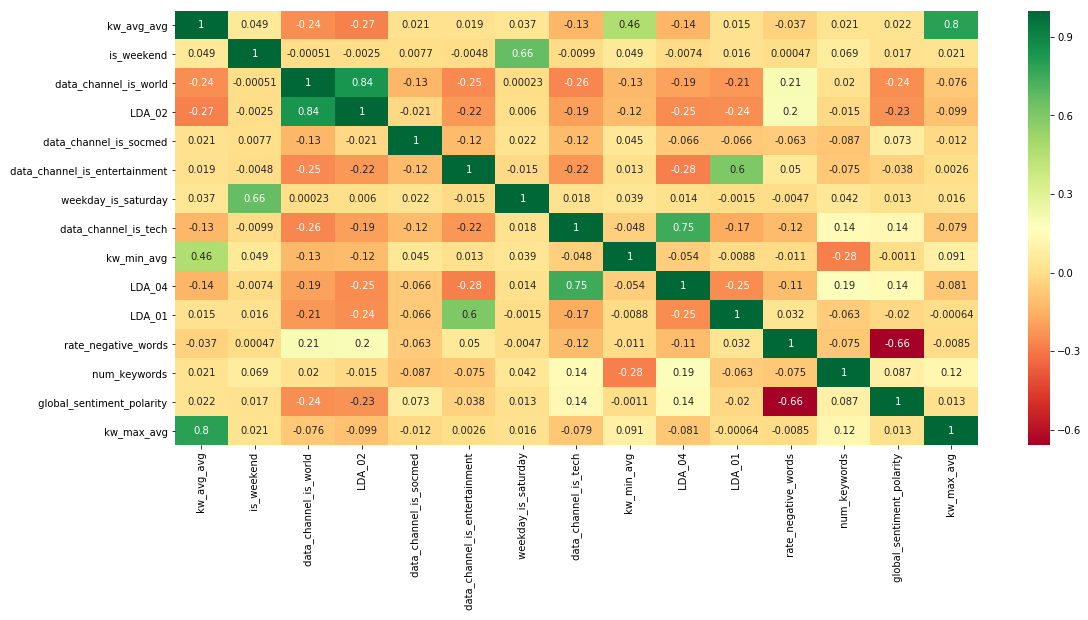

In [14]:
X1 = X[features_list]
plt.subplots(1,1,figsize=(18,8))
sns.heatmap(X1.corr(),annot=True,cmap="RdYlGn")

Green patches other than diagonal are the once to check and consider one of them. Following pairs are correlated features. The highlighted ones are features whose scores are higher in either **Correlation** and/or **ANOVA**

- **kw_avg_avg** - kw_max_avg
- **kw_avg_avg** - kw_min_avg
- **is_weekend** - weekday_is_saturday
- **data_channel_is_world** - LDA_02
- **data_channel_is_entertainment** - LDA_01
- **data_channel_is_tech** - LDA_04 

Following features should be remvoed from above list: kw_max_avg, kw_min_avg, weekday_is_saturday, LDA_02, LDA_01, LDA_04



In [15]:
features_to_remove = [' kw_max_avg',' kw_min_avg',' weekday_is_saturday',' LDA_02',' LDA_01',' LDA_04']
lst = list(features_list.values)
selected_features = [e for e in lst if e not in features_to_remove]

## Let us take top 6
# selected_features = selected_features[:6]

selected_features 

[' kw_avg_avg',
 ' is_weekend',
 ' data_channel_is_world',
 ' data_channel_is_socmed',
 ' data_channel_is_entertainment',
 ' data_channel_is_tech',
 ' rate_negative_words',
 ' num_keywords',
 ' global_sentiment_polarity']

By using two features selection techniques we found 20 top features and then we selected common features among them and then removed correlated features. We get the list of features as shown above. They are in the order of importance 

# Exploratory Data Analysis
Let us now perform some deep exploratory data analysis

### Shares vs kw_avg_avg
This is feature which is most impacting, as per statistics. Let us see how it looks

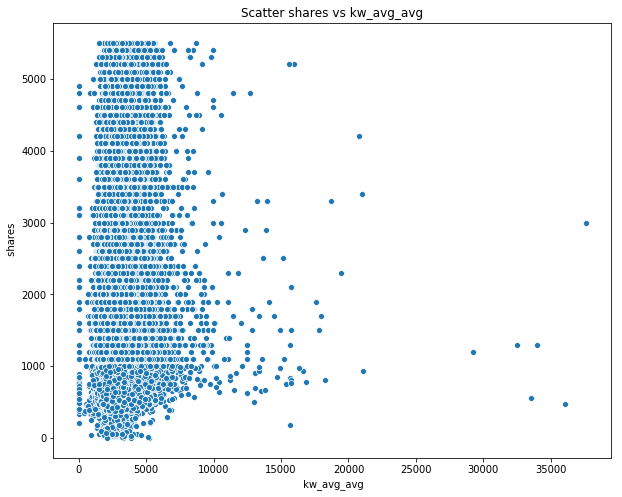

In [16]:
plt.subplots(1,1,figsize=(10,8))

plt.subplot(1,1,1)

plt.title('Scatter shares vs kw_avg_avg')
sns.scatterplot(data=df, x=' kw_avg_avg', y=' shares', ci=None)



We can see that articles published on weekend is getting shared more than weekday. The same is explained below

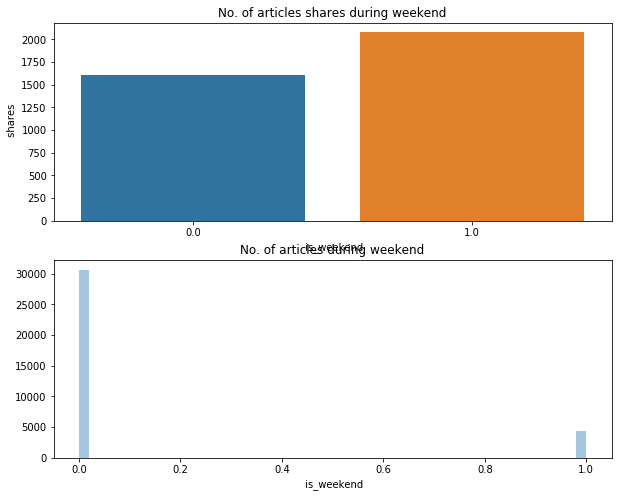

In [17]:
plt.subplots(2,1,figsize=(10, 8))

plt.subplot(2,1,1)
plt.title('No. of articles shares during weekend')
sns.barplot(data=df, x=' is_weekend', y=' shares', ci=False)

plt.subplot(2,1,2)
plt.title('No. of articles during weekend')
sns.distplot(df[' is_weekend'], hist=True, kde=False)

### No. of shares vs weekday of the article
Let us get a new column with weekday to see how the shares are varying with that column

In [18]:
index = 100
df['weekday'] = df[' weekday_is_monday'] * 2 ** 1 + \
      df[' weekday_is_tuesday'] * 2 ** 2 + \
      df[' weekday_is_wednesday'] * 2 ** 3 + \
      df[' weekday_is_thursday'] * 2 ** 4 + \
      df[' weekday_is_friday'] * 2 ** 5 + \
      df[' weekday_is_saturday'] * 2 ** 6 + \
      df[' weekday_is_sunday'] * 2 ** 7 
    
# np.log2(val)
df.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,weekday
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,2.0
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,2.0
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,2.0
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,2.0
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,2.0


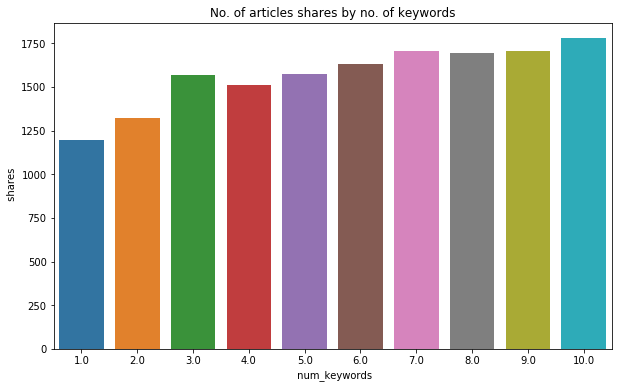

In [19]:
plt.subplots(1,1,figsize=(10, 6))

plt.subplot(1,1,1)
plt.title('No. of articles shares by no. of keywords')
sns.barplot(data=df, x=' num_keywords', y=' shares', ci=False)

We can see that no. of shares increase with key words in the meta data

Next up we will see how *no. of shares* and *rate_negative_words* featrues are correlated

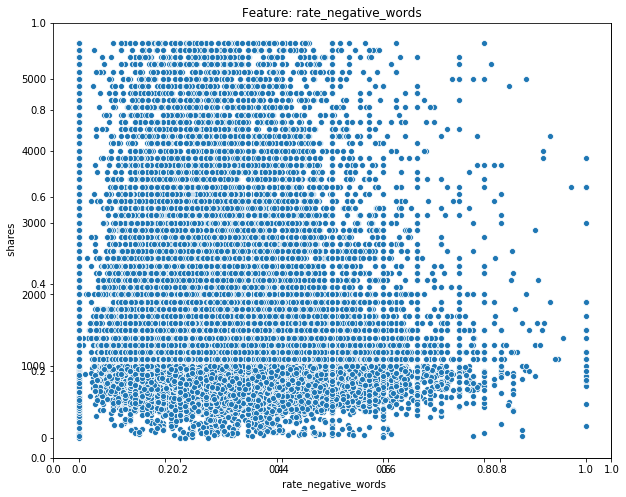

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
# ax.set_yscale('log')
plt.title('Feature: rate_negative_words')
sns.scatterplot(data=df, x=' rate_negative_words', y=' shares', ci=None)    

The above scatterplot is very sparse, but we can observe that there is a correlation

In [21]:
def token_group(x):
    if x < 100:
        return 1
    elif x >=100 and x<500:
        return 2
    elif x >=500 and x<1000:
        return 3
    elif x >=1000 and x<2000:
        return 4
    else: 
        return 5
    
df['token_group'] =  df[' n_tokens_content'].apply(token_group)

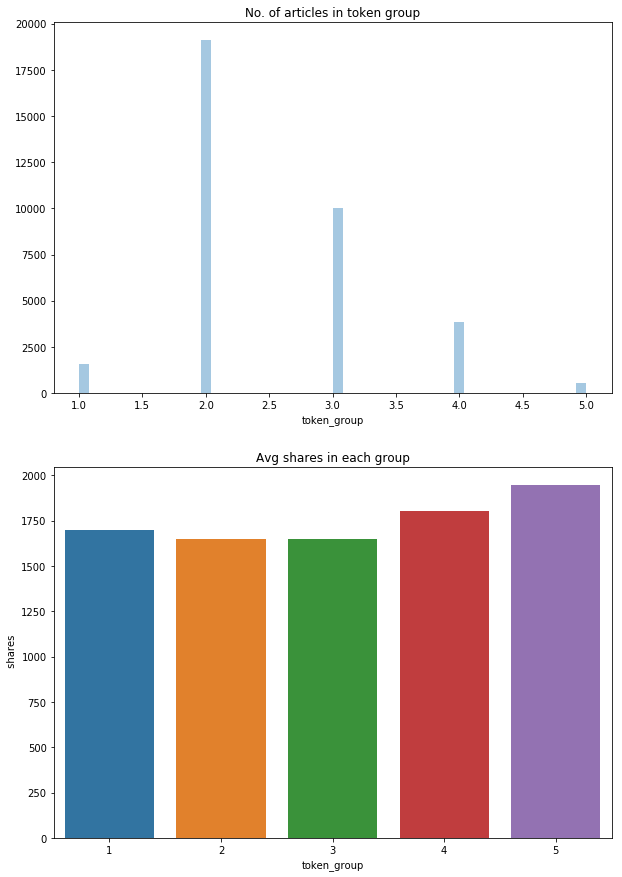

In [22]:
plt.subplots(2,1,figsize=(10,15))

plt.subplot(2,1,1)
plt.title('No. of articles in token group')
sns.distplot(df.token_group, hist=True, kde=False)
plt.subplot(2,1,2)
plt.title('Avg shares in each group')
sns.barplot(data=df, x='token_group', y=' shares', ci=None)

We have most of the articles in group 2, which is with token length in the range of 100 to 500. As the articles size is increasing, we see avg no. shares has also increased

# Build Model

### Baseline Model
We have ```selected_features``` as part of feature selection section. Let us try to build naive (Baseline) model based on simple linear model

First of all, let us split the train and test sets for the model

In [23]:
X = X[selected_features]

In [24]:
# print(X[selected_features].shape)
# print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [25]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We use MSE and R2 as Metrics

In [26]:
results = model.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)

MSE:  1145580.3858106323   R2 Score:  0.0862382381184591


As expected the R2 score is pretty bad. 


In [27]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, y_train)
X_ = poly.fit_transform(X_test)
results = regr.predict(X_)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)

MSE:  1137250.8802921632   R2 Score:  0.09288219233802464


Polynominal algorithm could not finish as 9 features, its too much to calculate the multiple possible poly degrees
However, in one of the previous versions, we have run and following is the output 

```
Model with Polynominal Degree 1 MSE:  1138058.1341509074   R2 Score:  0.08366289295516138
Model with Polynominal Degree 2 MSE:  1128850.3833187486   R2 Score:  0.09107675302675189
Model with Polynominal Degree 3 MSE:  1131198.7487819889   R2 Score:  0.08918590549419136
Model with Polynominal Degree 4 MSE:  1133594.5157797942   R2 Score:  0.08725689138318526
Model with Polynominal Degree 5 MSE:  1140495.5739477822   R2 Score:  0.08170032490609536
Model with Polynominal Degree 6 MSE:  2199982.8449245617   R2 Score:  -0.7713734080645245
```



### Random Forest Regressor
We will use Gridsearch with cross validation to get best parameter for RandomForest Algo

In [28]:

# # model2 = RandomForestRegressor(n_estimators=5, max_depth=1000 )
# # model2.fit(X_train, y_train)

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 5)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5 ]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True]

# param_grid = {
#     'bootstrap': bootstrap,
#     'max_depth': max_depth,
#     'max_features': max_features,
#     'min_samples_leaf': min_samples_leaf,
#     'min_samples_split': min_samples_split,
#     'n_estimators': n_estimators
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)



In [29]:
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

In [30]:
# grid_search.best_params_

In [31]:
# model2 = grid_search.best_estimator_
# results2 = model2.predict(X_test)
# score1 = metrics.mean_squared_error(y_test,results2 )
# score2 = metrics.r2_score(y_test,results2 )
# print('MSE: ',score1, '  R2 Score: ', score2)

The above Gridsearch Algorthm has been executed in version 6 with following output. It took 281 min to get the best hyperparameters for RandomSearchRegression. 
```
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.2min
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 79.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 168.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 268.8min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 281.4min finished
Out[31]:
GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [10, 35, 60, 85, 110, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 575, 1050, 1525, 2000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)
```

Best parameters are given below:
```
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 1525}
```

With above setup, the score was :
```
MSE:  1104065.159504597   R2 Score:  0.0931234303865699
```

With above parameters, let us try to build RandomForest model

In [32]:
model2 = RandomForestRegressor(bootstrap= True, max_depth = 10, 
 max_features = 'sqrt',
 min_samples_leaf =  10, 
 min_samples_split = 8,
 n_estimators = 1550)

model2.fit(X_train, y_train)
results2 = model2.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results2 )
score2 = metrics.r2_score(y_test,results2 )
print('MSE: ',score1, '  R2 Score: ', score2)

MSE:  1130097.1977231125   R2 Score:  0.09858826209026783


We can see best parameters have  greatly improved the model. 

### LightGBM algorithm
**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with many advantages

In [33]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.015
params['boosting_type'] = 'gbdt'
# params['boosting_type'] = 'dart'
params['objective'] = 'regression'
params['metric'] = 'mse'
params['sub_feature'] = 0.99
params['num_leaves'] = 10
params['min_data'] = 100
params['max_depth'] = 10000
y_train=y_train.ravel()
reg= lgb.train(params, d_train, 100)
results=reg.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)

MSE:  1148488.7933793382   R2 Score:  0.0839183733083001


Wow! Light GBM without much tuning we got much better results. 

**We can find best hyperparameters for LightGBM as improvement**

Up next, let us try to create a GridSearchCV for LightGBM

In [34]:
# uniform(loc=0.2, scale=0.8)
estimator = lgb.LGBMRegressor(boosting_type= 'gbdt', metric='mse',objective='regression')

In [35]:
param_grid = {
    'learning_rate': [0.005, 0.01, 0.1, 0.5],
    'n_estimators': [int(x) for x in np.linspace(start = 20, stop = 2000, num = 7)],
    'num_leaves' : [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)],
    'sub_feature' : [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 3)]
}
gbm = GridSearchCV(estimator, param_grid, cv=3)

In [36]:
gbm.fit(X_train, y_train)
print('Best parameters found by grid search are:', gbm.best_params_)

gbm_best = gbm.best_estimator_
results = gbm_best.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)


Best parameters found by grid search are: {'learning_rate': 0.005, 'n_estimators': 1340, 'num_leaves': 10, 'sub_feature': 0.55}
MSE:  1129265.9364453114   R2 Score:  0.09925131007816612


### Neural Networks
Let us build a deep NN model for this regression

In [37]:
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], init='uniform', activation='relu'))
model.add(Dense(64, init='uniform', activation='relu'))
model.add(Dense(64, init='uniform', activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 6,657
Trainable params: 6,657
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, input_dim=9, activation="relu", kernel_initializer="uniform")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="uniform")`
  after removing the cwd from sys.path.


The model summary is shown above. Let us compile now

In [38]:
model.compile(loss='mse', optimizer='Adamax', metrics=['mse'])
history = model.fit(X_train, y_train, epochs=5000, batch_size=50,  verbose=0, validation_split=0.2)

In [39]:
results=model.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)

MSE:  1144945.3030087245   R2 Score:  0.08674480613166857


We see that the R2 score is around 0.77. 

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


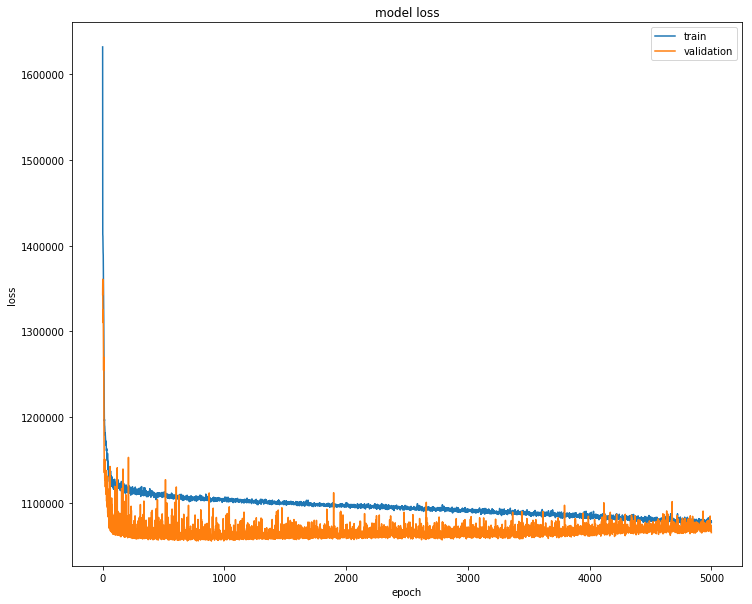

In [40]:
print(history.history.keys())
# "Loss"
plt.subplots(1,1,figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

The above graph shows the improvement of loss with respect to epochs

### XGBoost
Let us now try to implement XGBoost Algorithm


In [41]:
xgb = xgboost.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=2)
xgb.fit(X_train,y_train)
results=xgb.predict(X_test)
score1 = metrics.mean_squared_error(y_test,results )
score2 = metrics.r2_score(y_test,results )
print('MSE: ',score1, '  R2 Score: ', score2)

[04:11:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE:  1129419.3632138846   R2 Score:  0.09912893061347927


# Summary
With all the above we can summarize our findings as below

|Model|Parameters|MSE |R2 Score|
|-| -|-|-|
|Linear Model (**Baseline**) |-|1157909|0.071 |
|Polynomial Model| Degree = 2|1096834|0.092 | 
|Random Forest|max_depth=10,max_features='sqrt',min_samples_leaf=10,min_samples_split=8, n_estimators=1550|1150355|0.077|
|LightGBM|learning_rate= 0.15,boosting_type= 'gbdt,objective = 'regression',metric= 'mse',sub_feature= 0.3,num_leaves= 10,min_data = 1200,max_depth= 100|1094217|0.094|
|Neural Net|4 layers= 9,64,32,32|1114359|0.078|
|XGBoost| | | 0.077|